## Icon Visual Complexity Analysis

This notebook analyzes the **visual complexity** of a collection of icon images using the following metrics:

- **Edge Density** – Measures how many edges are present in the image using the Canny edge detector.
- **Entropy** – Quantifies the amount of information or randomness in the grayscale intensity distribution.

Each icon is scored based on the metric values, and icons are sorted in ascending order of visual complexity.

The output includes:
- A plot of the icons, labeled with their filenames.
- A summary table of metric values and the complexity scores.

You can customize this script to include additional metrics such as:
- **Horizontal & Vertical Symmetry**
- **Gabor Texture**
- **Spatial Frequency**

I didn't include them as the results based on them are not intuitive. 

To customize the analysis, you can edit the `included_metrics` list at the top of the code.


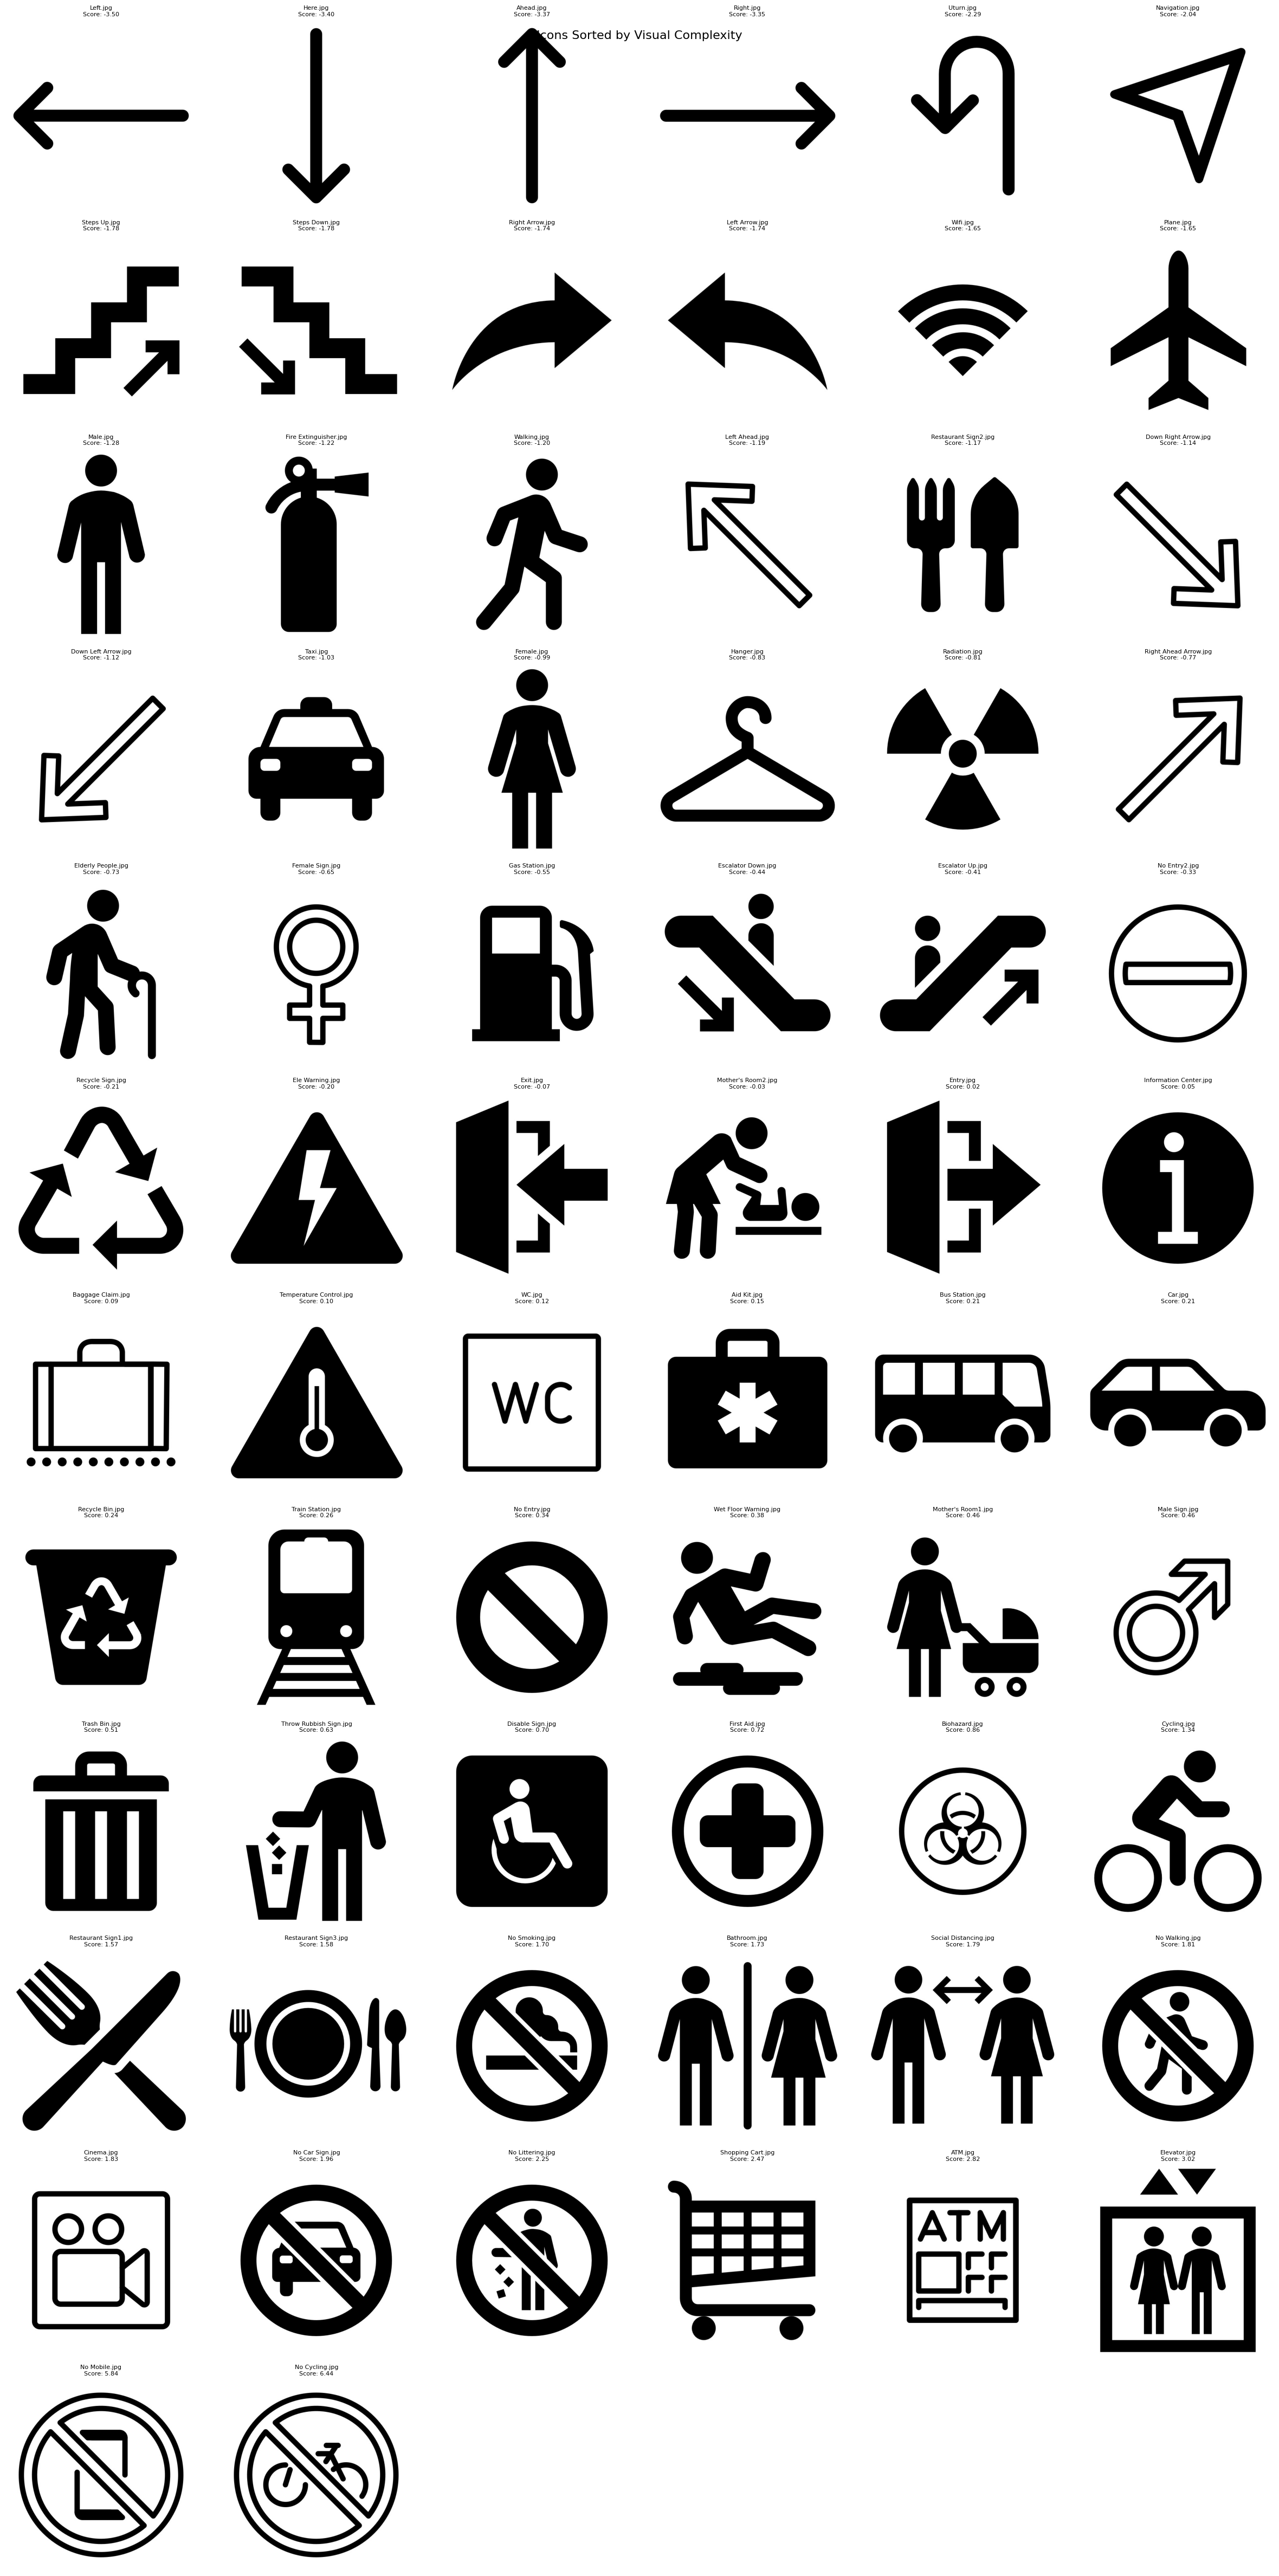

Sorted Complexity Table:
                   Filename  edge_density  entropy  Complexity Score
0                  Left.jpg        0.0040   0.5015           -3.5046
1                  Here.jpg        0.0040   0.5285           -3.3984
2                 Ahead.jpg        0.0040   0.5351           -3.3733
3                 Right.jpg        0.0040   0.5417           -3.3473
4                 Uturn.jpg        0.0058   0.7097           -2.2926
5            Navigation.jpg        0.0053   0.7995           -2.0351
6              Steps Up.jpg        0.0061   0.8207           -1.7833
7            Steps Down.jpg        0.0061   0.8220           -1.7784
8           Right Arrow.jpg        0.0051   0.8809           -1.7428
9            Left Arrow.jpg        0.0051   0.8826           -1.7360
10                 Wifi.jpg        0.0064   0.8392           -1.6538
11                Plane.jpg        0.0056   0.8815           -1.6452
12                 Male.jpg        0.0060   0.9503           -1.2785
13    Fir

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.preprocessing import StandardScaler
import cairosvg
import tempfile

# --- Configuration: Choose which metrics to include ---
included_metrics = [
    'edge_density',
    'entropy'
]

# --- Step 1: Compute complexity metrics ---
def compute_metrics(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape
    total_pixels = height * width

    metrics = {}

    # Edge density
    if 'edge_density' in included_metrics:
        edges = cv2.Canny(image, 200, 300)
        metrics['edge_density'] = np.sum(edges > 0) / total_pixels

    # Entropy
    if 'entropy' in included_metrics:
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist_norm = hist / hist.sum()
        metrics['entropy'] = -np.sum(hist_norm * np.log2(hist_norm + 1e-8))

    # Horizontal symmetry
    if 'horizontal_symmetry' in included_metrics:
        flipped = cv2.flip(image, 1)
        metrics['horizontal_symmetry'] = 1.0 - np.mean(np.abs(image - flipped)) / 255.0

    # Vertical symmetry
    if 'vertical_symmetry' in included_metrics:
        flipped = cv2.flip(image, 0)
        metrics['vertical_symmetry'] = 1.0 - np.mean(np.abs(image - flipped)) / 255.0

    return [metrics[m] for m in included_metrics]

# --- Step 2: Load all images and extract metrics ---
def load_metrics(folder_path):
    files = []
    metrics = []
    for f in os.listdir(folder_path):
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.svg')):
            try:
                path = os.path.join(folder_path, f)
                m = compute_metrics(path)
                files.append(f)
                metrics.append(m)
            except Exception as e:
                print(f"Failed to process {f}: {e}")
    return files, metrics

# --- Step 3: Compute a complexity score and sort ---
def sort_by_complexity(files, metrics):
    metrics = np.array(metrics)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(metrics)

    complexities = np.sum(scaled, axis=1)
    data = list(zip(files, metrics.tolist(), complexities))
    data.sort(key=lambda x: x[2])
    return data

# --- Step 4: Display sorted icons and table ---
def display_sorted(data, folder_path):
    num = len(data)
    cols = min(num, 6)
    rows = int(np.ceil(num / cols))

    # Show images
    plt.figure(figsize=(4 * cols, 4 * rows))
    for idx, (fname, metrics, complexity) in enumerate(data):
        file_path = os.path.join(folder_path, fname)
        if fname.lower().endswith('.svg'):
            with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_png:
                cairosvg.svg2png(url=file_path, write_to=temp_png.name)
                img = Image.open(temp_png.name).convert('RGB')
        else:
            img = Image.open(file_path).convert('RGB')

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.title(f"{fname}\nScore: {complexity:.2f}", fontsize=8)
        plt.axis('off')

    plt.suptitle("Icons Sorted by Visual Complexity", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Show table
    col_names = ['Filename'] + included_metrics + ['Complexity Score']
    table_data = []
    for fname, m, complexity in data:
        table_data.append([fname] + [round(v, 4) for v in m] + [round(complexity, 4)])
    df = pd.DataFrame(table_data, columns=col_names)
    # Ensure full table is printed without truncation
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    
    print("Sorted Complexity Table:")
    print(df.to_string(index=True))

# --- Run ---
folder_path = r'C:\Users\localadmin\OneDrive - Johns Hopkins\EVA_WST\HighRes Icons'  

files, metrics = load_metrics(folder_path)
sorted_data = sort_by_complexity(files, metrics)
display_sorted(sorted_data, folder_path)
